In [1]:
# from __future__ import division
import sys, os, copy
BIN = os.path.expanduser("../../../")
sys.path.append(BIN)
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, e
import time

In [2]:
from PyHEADTAIL_feedback.signal_tools.signal_generators import SimpleBeam, SimpleCircularPointBeam
from PyHEADTAIL_feedback.signal_tools.trackers_and_kickers import track_beam, Wake
from PyHEADTAIL_feedback.signal_tools.plotters import plot_beams

9788.2237537
{}
wakedata.shape(11822, 6)
Numpy running time: 23.1081540585
Cython running time: 18.5535061359
FFT running time: 15.0591750145
FFT convolve running time: 3.66630601883

Integarated Cython error: 1.0211544662e-20
Integarated FFT error: 5.09719033213e-19
Integarated FFT convolve error: 1.16576631679e-19


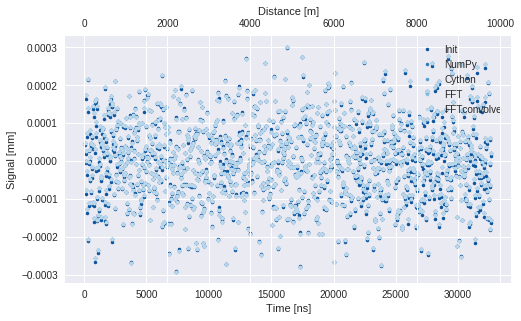

In [3]:


# SIMULATION PARAMETERS
# ---------------------
n_turns = 10000
n_buckets_per_bunch = 1

# MACHINE PARAMETERS
#-------------------
circumference = 9770.14
p0 = 3300e9 * e / c
accQ_x = 109.28
beta_x = circumference / (2.*np.pi*accQ_x)
n_bunches=1306
bunch_spacing=25e-9
intensity=1e11


# GENERATES BEAM
# --------------
beam = SimpleCircularPointBeam(n_bunches, bunch_spacing, intensity, circular_overlapping=0)

# beam = SimpleBeam(n_bunches, bunch_spacing, bunch_length, intensity, n_slices, beta_x=beta_x)
beam.set_beam_paramters(p0)
beam.init_noise(1e-7)
# beam_map = (beam.z>3000.)*(beam.z<6000.)
# beam.x[beam_map] = beam.x[beam_map]+1e-3

# GENERATES WAKES
# --------------
wakedata = np.loadtxt('example_impedance.wake')
print 'wakedata.shape' + str(wakedata.shape)
data_t = wakedata[:,0]
data_x = wakedata[:,2]



# fig, ax1, ax11 = plot_beam(beam, label='init')
startTime = time.time()
trackers_numpy = [
    Wake(data_t,data_x,1, method = 'numpy')
]
beam_numpy = copy.deepcopy(beam)
track_beam(beam_numpy,trackers_numpy,n_turns,accQ_x)
print 'Numpy running time: ' + str(time.time() - startTime)

startTime = time.time()
trackers_cython = [
    Wake(data_t,data_x,1, method = 'cython')
]
beam_cython = copy.deepcopy(beam)
track_beam(beam_cython,trackers_cython,n_turns,accQ_x)
print 'Cython running time: ' + str(time.time() - startTime)

startTime = time.time()
trackers_fft = [
    Wake(data_t,data_x,1, method = 'fft')
]
beam_fft = copy.deepcopy(beam)
track_beam(beam_fft,trackers_fft,n_turns,accQ_x)
print 'FFT running time: ' + str(time.time() - startTime)

startTime = time.time()
trackers_fftconvolve = [
    Wake(data_t,data_x,1, method = 'fftconvolve')
]
beam_fftconvolve = copy.deepcopy(beam)
track_beam(beam_fftconvolve,trackers_fftconvolve,n_turns,accQ_x)
print 'FFT convolve running time: ' + str(time.time() - startTime)
# fig, ax1, ax11 = plot_beam(beam_fft,fig=fig, ax1=ax1, ax11=ax11)

beams = [
    beam,
    beam_numpy,
    beam_cython,
    beam_fft,
    beam_fftconvolve,
]

print ''
print 'Integarated Cython error: ' + str(np.sum(beam_cython.x - beam_numpy.x))
print 'Integarated FFT error: ' + str(np.sum(np.abs(beam_fft.x - beam_numpy.x)))
print 'Integarated FFT convolve error: ' + str(np.sum(np.abs(beam_fftconvolve.x - beam_numpy.x))) 

labels = [
    'Init',
    'NumPy',
    'Cython',
    'FFT',
    'FFTconvolve',
]
fig, ax1, ax11 = plot_beams(beams,labels)

plt.show()